# Calib sensor functions

NB study: module calib_sensor_functions.py in invisible_cities/reco

In [1]:
import os
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

import time
import glob
import tables as tb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce
%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

2018-02-24 13:17:25


In [2]:
from IPython.display import Image

In [3]:
from pytest import approx

In [4]:
from collections import namedtuple
from enum import Enum

In [5]:
from invisible_cities.reco import calib_sensors_functions as csf
from invisible_cities.core import core_functions as cf
from invisible_cities.types.ic_types  import minmax
from invisible_cities.core.testing_utils import all_elements_close

In [6]:
import invisible_cities.core.system_of_units as units
from invisible_cities.core.core_functions import timefunc
from typing import  NamedTuple

In [7]:
from invisible_cities.sierpe  import fee as FE
import scipy.signal as signal
import scipy.stats as scs

In [8]:
from numba import jit
from functools import reduce
from operator import add

In [9]:
import invisible_cities.sierpe.waveform_generator as wfg

## Utils

In [10]:
def color_generator(cx = ['b', 'k', 'r', 'y', 'g'] ):
    i=0
    while True:
        if i < len(cx):
            yield cx[i]
            i+=1
        else:
            i=0
            yield cx[i]
    

In [11]:
def plot_wfm(wfm):
    plt.plot(wfm)
    plt.grid(True)
    plt.xlabel(r't (time units)')
    plt.ylabel(r'q (charge/energy units)')


def plot_waveforms(wfms):
    c = color_generator()
    for wfm in wfms:
            plt.plot(wfm, next(c))
    plt.grid(True)
    plt.xlabel(r't (time units)')
    plt.ylabel(r'q (charge/energy units)')


def plot_waveform(wfms, sensor_number=0):
    plot_wfm(wfms[sensor_number])

## Statistics

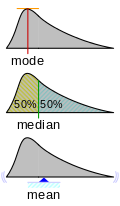

In [12]:
Image(filename='./Visualisation_mode_median_mean.svg.png') 

In [13]:
@timefunc
def means_from_waveforms(wfms):
    """Given an array of waveforms wfms[sensors][waveform] return mean[sensors]"""
    return np.mean(wfms, axis=1)
   

In [14]:
@timefunc
def medians_from_waveforms(wfms):
    """Given an array of waveforms wfms[sensors][waveform] return median[sensors]"""
    return np.median(wfms, axis=1)

In [15]:
@timefunc
def modes_from_waveforms(wfms):
    """Given an array of waveforms wfms[sensors][waveform] return mode[sensors]"""
    return csf.mode(wfms, axis=1)

@timefunc
def amodes_from_waveforms(wfms):
    """Given an array of waveforms wfms[sensors][waveform] return mode[sensors]"""
    return csf.amode(wfms, axis=1)

## Deconvolution and waveform subtraction

In [16]:
@jit
def deconv_simple(wfm, coef):
    """
    Deconvolution of the fine-grained fee signal (no DAQ)
    no noise
    using true start and end of signals
    """

    signal = wfm - np.mean(wfm)
    acum = np.zeros(len(signal))

    acum[0] = coef * signal[0]
    for n in np.arange(1, len(signal)):
        acum[n] = acum[n-1] + signal[n]

    signal_r = signal + coef*acum

    #return signal_r.astype(int)
    return signal_r

In [17]:
@timefunc
def deconv_pmts(wfms, coef):
    return np.array([deconv_simple(wfm, coef) for wfm in wfms])
    

In [18]:
@timefunc
def subtract_baseline(wfms, bls_mode=csf.BlsMode.mean):
    return csf.subtract_baseline(wfms, bls_mode=bls_mode)

## Waveform study

### Waveform structure:

wfms[sensor][waveform]

- Generate FEE waveforms: FEE introduces a HPF: e.g, a derivative. 
- Generate BLR waveforms: Waveforms are decimated by the DAQ but not passed by the HPF.

### The case with no  noise

In [19]:
fee = FE.FEE(noise_FEEPMB_rms=0*FE.NOISE_I,noise_DAQ_rms=0*FE.NOISE_DAQ)
coef = fee.freq_LHPFd*np.pi

### Waveform parameters

- The generator starts by generating a square waveform in bins of 1 ns.
- The waveform is decimated by the DAQ, noise is added and the effect of the electronics is added


In [20]:
wfp = wfg.WfmPar(w_type='square', t_tot=5000*25,t_pre=600*25,
                 t_rise_s2=20*25,t_flat_s2=500*25,noise=0,q_s2=50)

In [21]:
square_wfm   =  wfg.square_waveform(wfp)

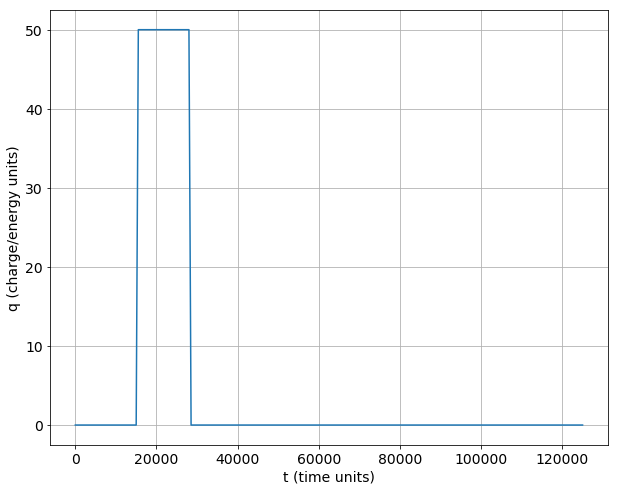

In [22]:
plot_wfm(square_wfm)

- The pmt simulation decimates the waveform and returns two waveforms:
    - a FEE waveform with negative swing (effect of the electronics filter)
    - a BLR waveform whithout the filter

In [23]:
pmtwf = wfg.simulate_pmt_response(fee, square_wfm)

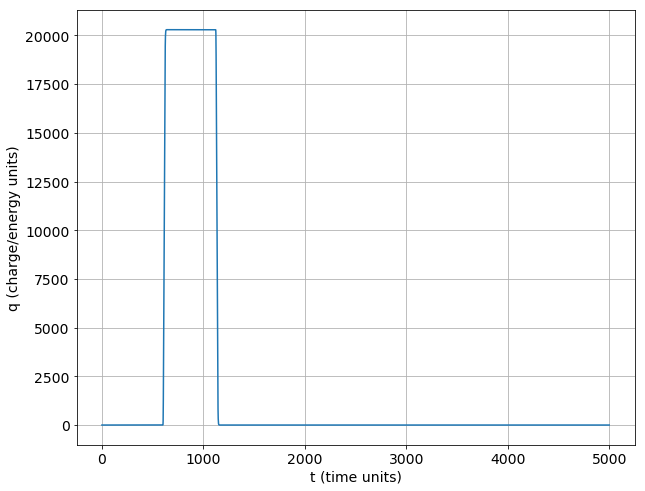

In [24]:
plot_wfm(pmtwf.blr)

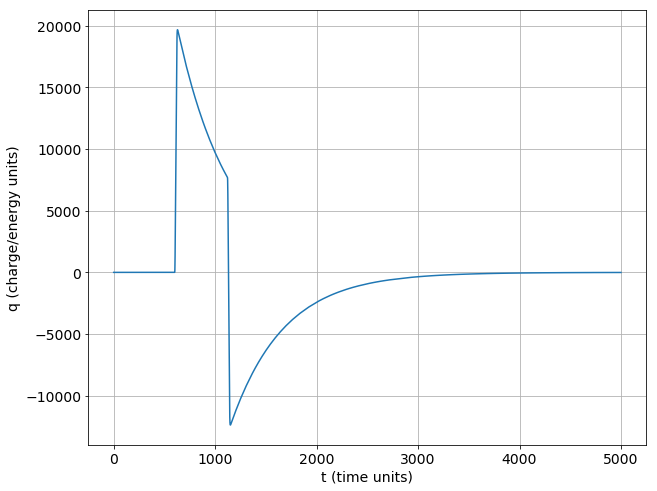

In [25]:
plot_wfm(pmtwf.fee)

- The effect of the FEE can be deconvolved and the baseline restored

In [26]:
pmtblr = deconv_simple(pmtwf.fee, coef)
pmtblr.dtype

dtype('float64')

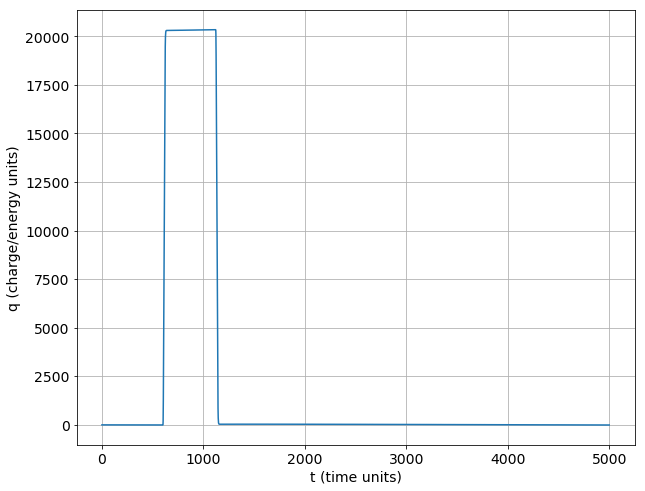

In [27]:
plot_wfm(pmtblr)

### The difference between the original BLR and the restored BLR can be computed.

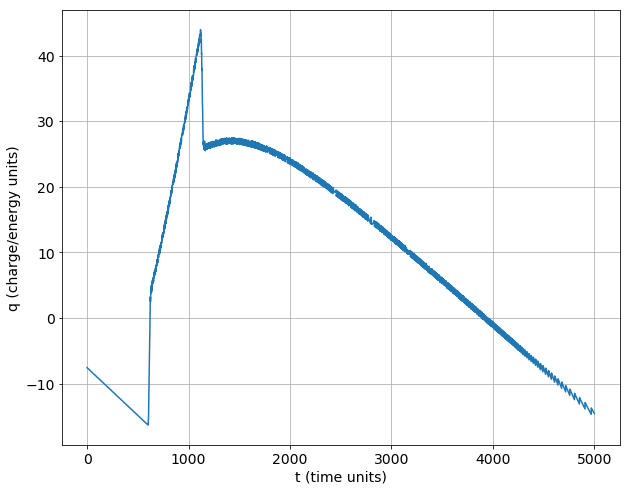

In [28]:
plot_wfm(pmtblr - pmtwf.blr)

#### The energy error is small

In [29]:
energy_error = np.sum(abs(pmtblr[500:1200] - pmtwf.blr[500:1200])) / np.sum(pmtwf.blr[500:1200])
energy_error

0.0014636790567978356

### Adding electronic noise does not change the energy error

In [30]:
fee = FE.FEE(noise_FEEPMB_rms=1*FE.NOISE_I,noise_DAQ_rms=1*FE.NOISE_DAQ)
coef = fee.freq_LHPFd*np.pi

In [31]:
pmtwf = wfg.simulate_pmt_response(fee, square_wfm)
pmtblr = deconv_simple(pmtwf.fee, coef)
energy_error = np.sum(abs(pmtblr[600:1200] - pmtwf.blr[600:1200])) / np.sum(pmtwf.blr[600:1200])
energy_error

0.0013153730865497252

### Adding waveform noise does not increase the energy error

In [32]:
wfp = wfg.WfmPar(w_type='square', t_tot=5000*25,t_pre=600*25,
                 t_rise_s2=20*25,t_flat_s2=500*25,noise=1,q_s2=50)

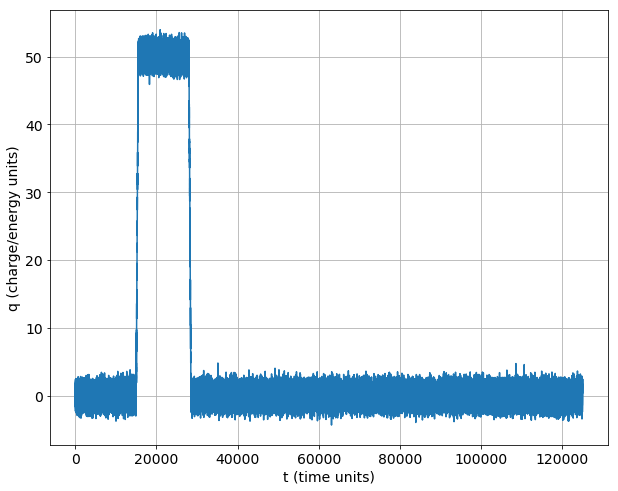

In [33]:
square_wfm   =  wfg.square_waveform(wfp)
plot_wfm(square_wfm)

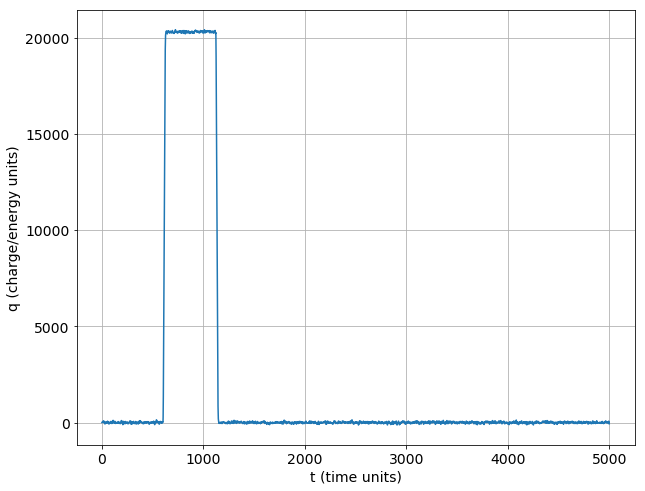

In [34]:
pmtwf = wfg.simulate_pmt_response(fee, square_wfm)
plot_wfm(pmtwf.blr)

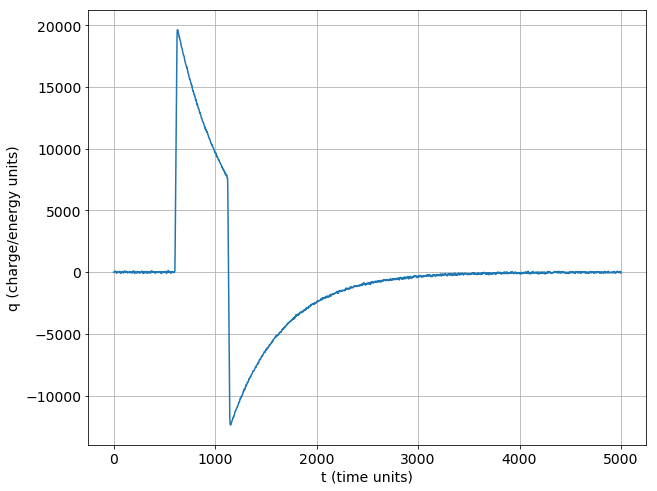

In [35]:
plot_wfm(pmtwf.fee)

In [36]:
pmtblr = deconv_simple(pmtwf.fee, coef)
energy_error = np.sum(abs(pmtblr[600:1200] - pmtwf.blr[600:1200])) / np.sum(pmtwf.blr[600:1200])
energy_error

0.0012684512899401148

### SawTeeth waveform

In [37]:
wfp2 = wfg.WfmPar(w_type='sawteeh', t_tot=5000*25,t_pre=600*25,
                 t_rise_s2=200*25,t_flat_s2=100*25,noise=0,q_s2=50)
wfm = wfg.sawteeth_waveform(wfp2)

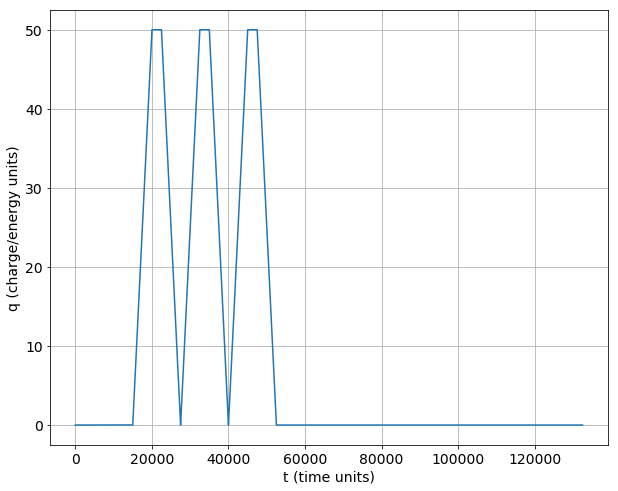

In [38]:
plot_wfm(wfm)

In [39]:
pmtwf = wfg.simulate_pmt_response(fee, wfm)

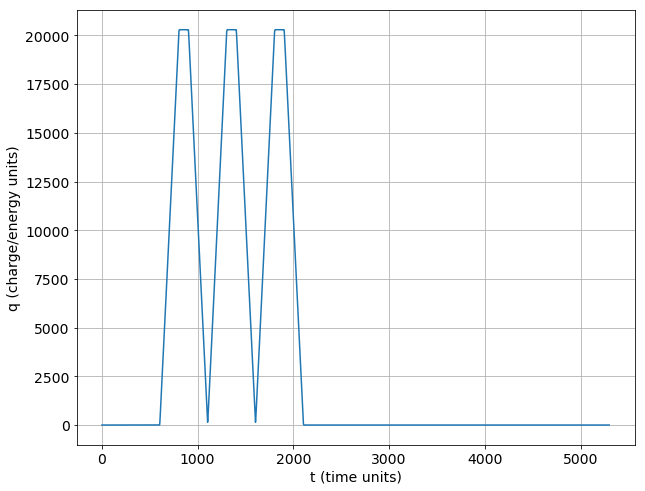

In [40]:
plot_wfm(pmtwf.blr)

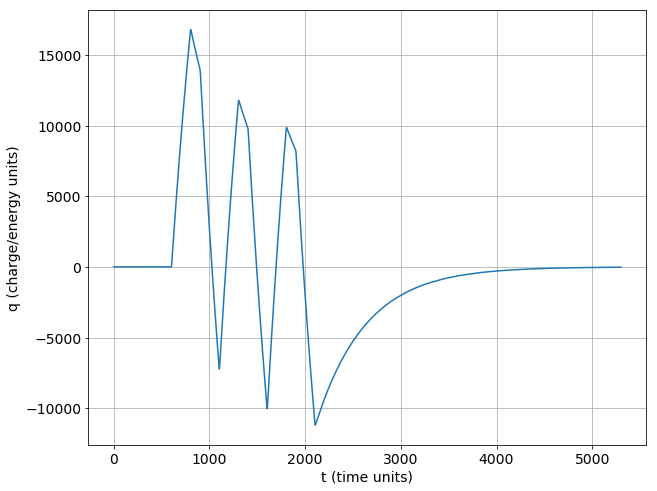

In [41]:
plot_wfm(pmtwf.fee)

In [42]:
pmtblr = deconv_simple(pmtwf.fee, coef)

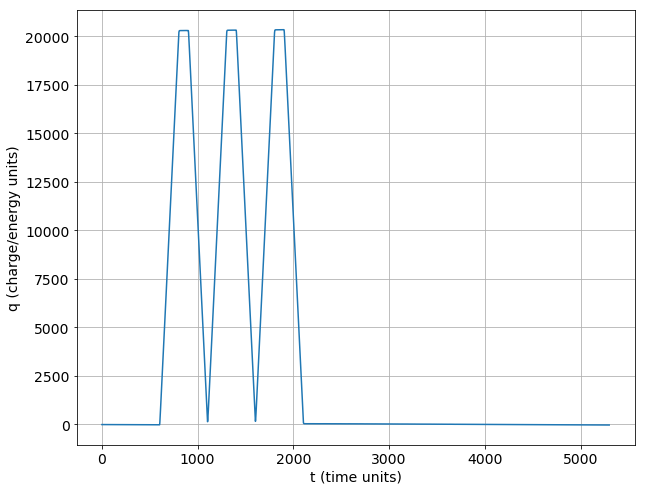

In [43]:
plot_wfm(pmtblr)

In [44]:
energy_error = np.sum(abs(pmtblr[500:2200] - pmtwf.blr[500:2200])) / np.sum(pmtwf.blr[500:2200])
energy_error

0.0017399210497097326

#### Summary PMTs:

- mean is used to compute the baseline. Mean is unbiased here, provided one lets the waveform return to the pedestal. 
- energy error introduced by calculation is very small

### SiPMs. The case of square waveforms.

SiPMs can be treated as square waveforms. In this case the total area of the waveform is not zero and the mean is biased. One can use instead the median or the mode.

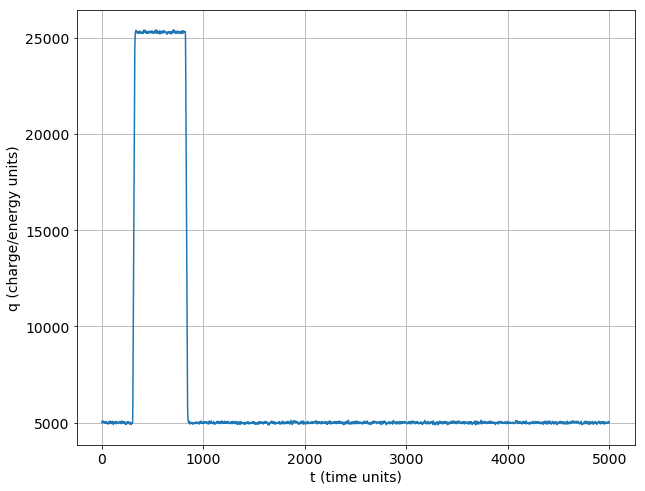

In [45]:
pedestal = 5000
wfp = wfg.WfmPar(w_type='square', t_tot=5000*25,t_pre=300*25,
                 t_rise_s2=20*25,t_flat_s2=500*25,noise=1,q_s2=50)
square_wfm   =  wfg.square_waveform(wfp)
pmtwf = wfg.simulate_pmt_response(fee, square_wfm)

sipmwf = pmtwf.blr + np.ones(len(pmtwf.blr)) * pedestal
plot_wfm(sipmwf)

- The generator allows to define the number of sensors and the pedestal. 

### PMT waveforms 

In [46]:
pedestal = 5000
nsensors =    5

wfms = wfg.waveform_generator(fee, wfp, nsensors=nsensors, pedestal=pedestal, random_t0=True)
pmts_fee  = wfms.fee
pmts_blr  = wfms.blr
sipms_wfm = wfms.blr
sipms_noped = np.array( [wfm - np.ones(len(wfm)) * pedestal for wfm in sipms_wfm]).astype(int)

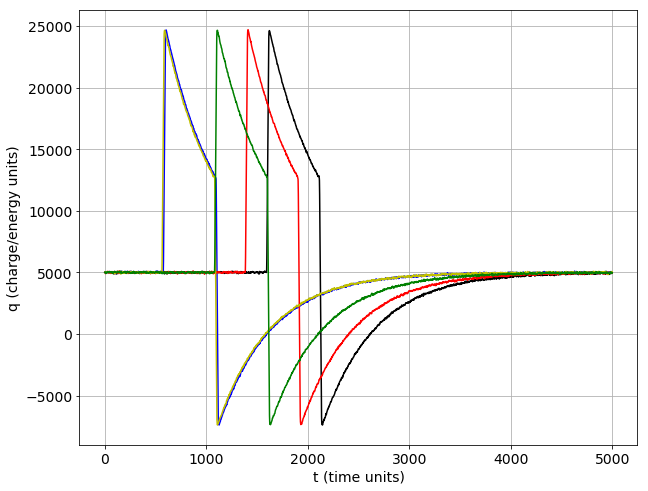

In [47]:
plot_waveforms(pmts_fee)

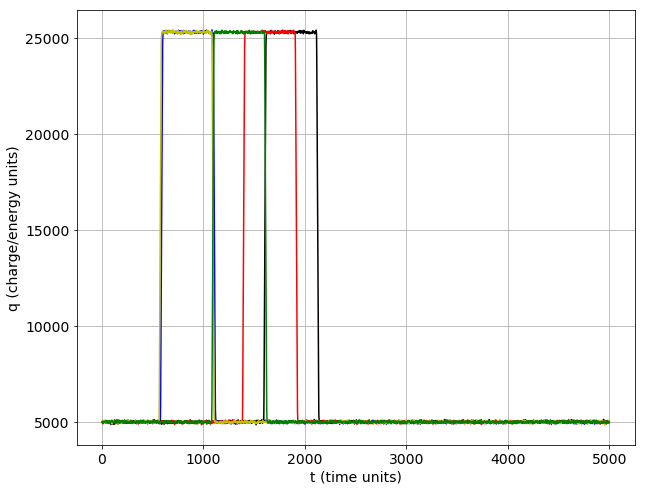

In [48]:
plot_waveforms(pmts_blr)

### Baseline can be restored and pedestral subtracted (same operation)

In [49]:
pmts_BLR = deconv_pmts(pmts_fee, coef)

Time spent in deconv_pmts: 0.0002028942108154297 s


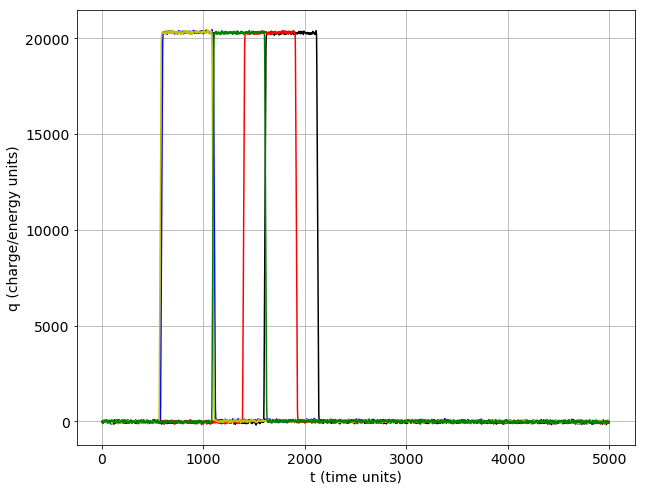

In [50]:
plot_waveforms(pmts_BLR)

### SiPMs

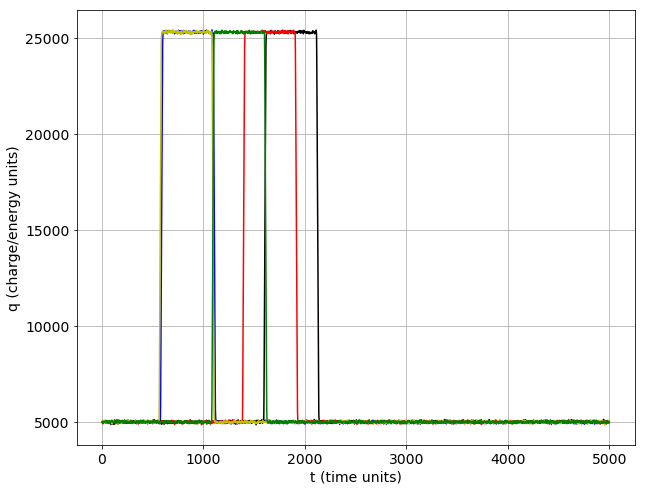

In [51]:
plot_waveforms(sipms_wfm )

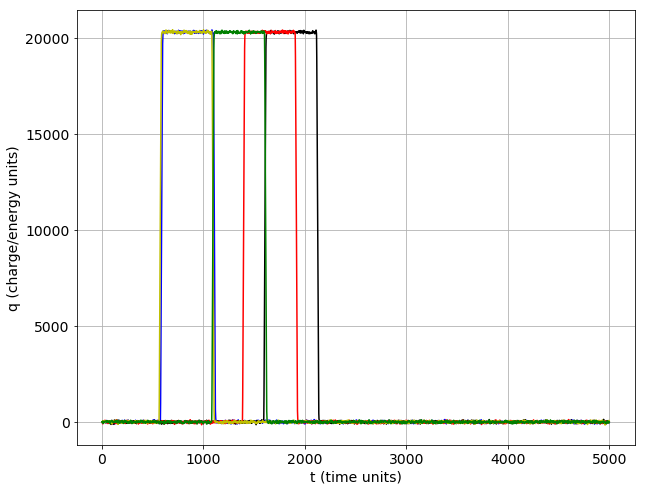

In [52]:
plot_waveforms(sipms_noped)

### Pedestal estimation using the mean

In [53]:
sipms_mean = subtract_baseline(sipms_wfm, bls_mode=csf.BlsMode.mean)

Time spent in subtract_baseline: 0.00026106834411621094 s


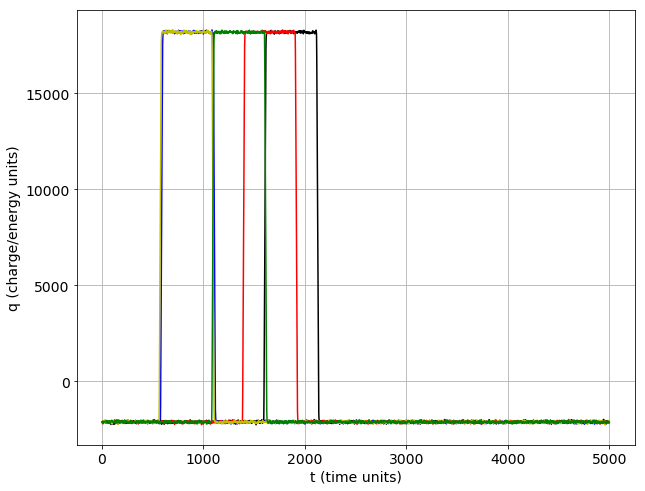

In [54]:
plot_waveforms(sipms_mean)

#### Notice that the mean is biased (since it is affected by the value of the square wave)

### Pedestal estimation using the median

In [55]:
sipms_median = subtract_baseline(sipms_wfm, bls_mode=csf.BlsMode.median)

Time spent in subtract_baseline: 0.0005466938018798828 s


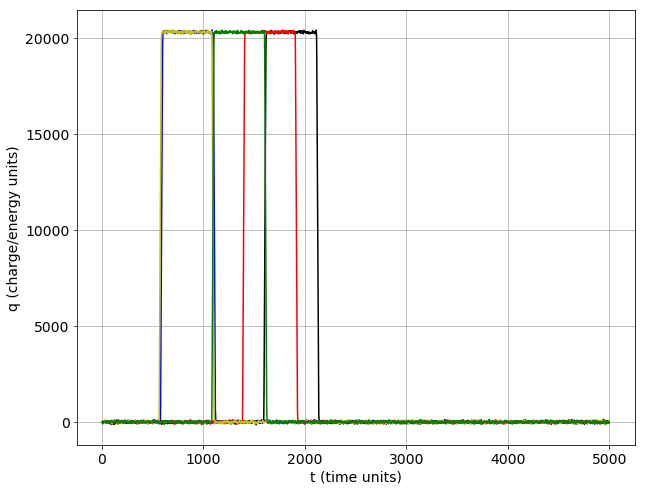

In [56]:
plot_waveforms(sipms_median)

#### The median, instead, is a good estimator of the baseline

### Pedestal estimation using the mode (use amode which is faster)

In [57]:
sipms_mode = subtract_baseline(sipms_wfm, bls_mode=csf.BlsMode.amode)

Time spent in subtract_baseline: 0.0007369518280029297 s


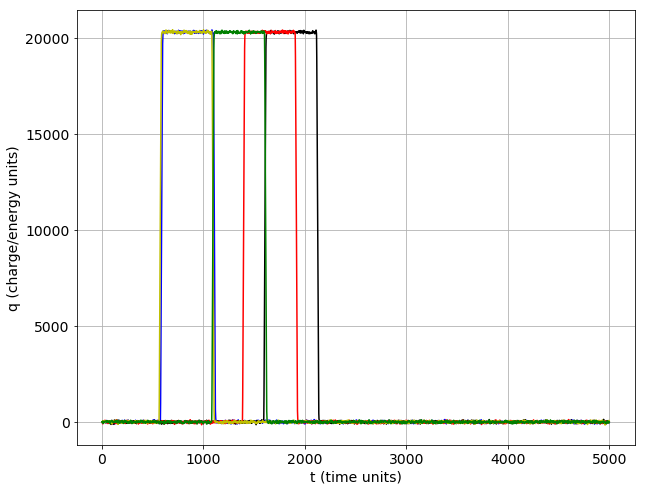

In [58]:
plot_waveforms(sipms_mode)

#### Mode is also a good estimator of pedestal

### Quantifying the difference

### Mean

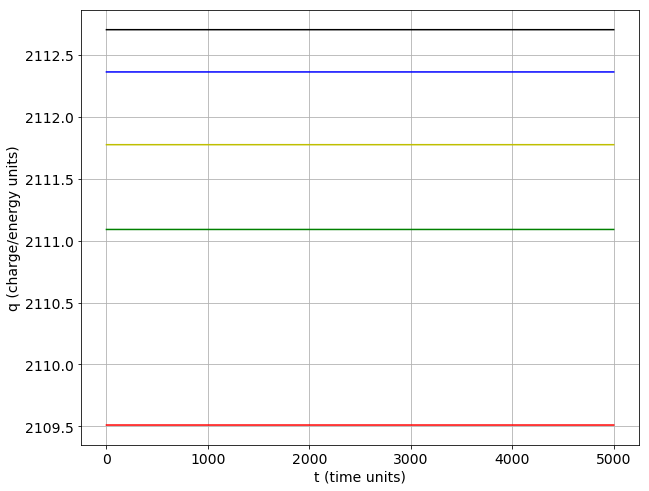

In [59]:
diffs =np.array([x - y for x, y in zip(sipms_noped, sipms_mean)])
plot_waveforms(diffs)

### Median

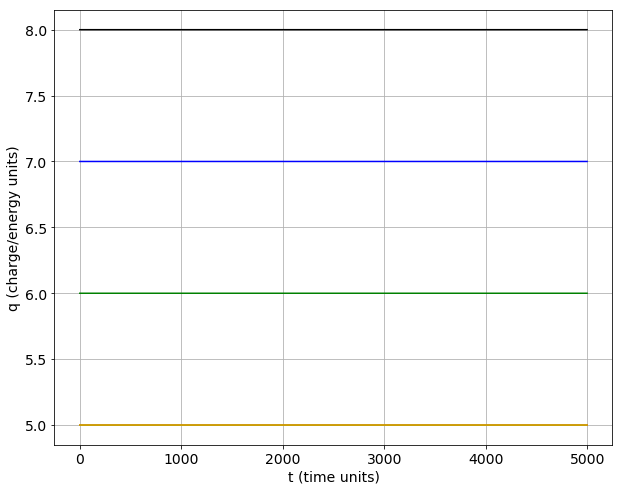

In [60]:
diffs =np.array([x - y for x, y in zip(sipms_noped, sipms_median)])
plot_waveforms(diffs)

### Mode

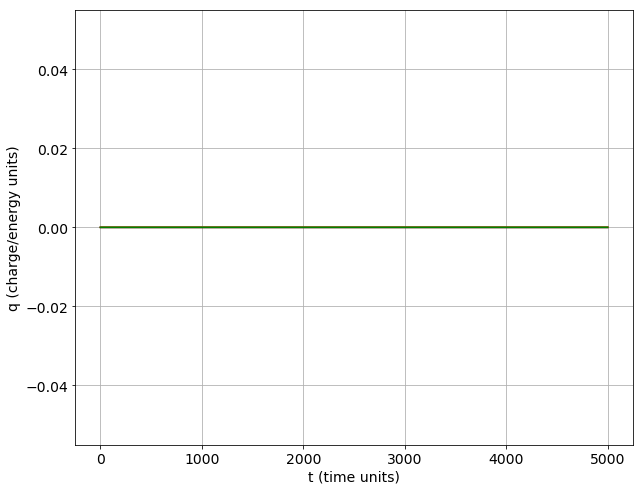

In [61]:
diffs =np.array([x - y for x, y in zip(sipms_noped, sipms_mode)])
plot_waveforms(diffs)

#### Outlook:

- For PMTs the BLR procedure computes the baseline.
- For SiPMs use the mode (fast version)

### Calibrate PMTs


In [62]:
pedestal = 5000
nsensors =    5

wfms = wfg.waveform_generator(fee, wfp, nsensors=nsensors, pedestal=pedestal, random_t0=False)
pmts_fee  = wfms.fee
pmts_blr  = wfms.blr
sipms_wfm = wfms.blr
sipms_noped = np.array( [wfm - np.ones(len(wfm)) * pedestal for wfm in sipms_wfm]).astype(int)

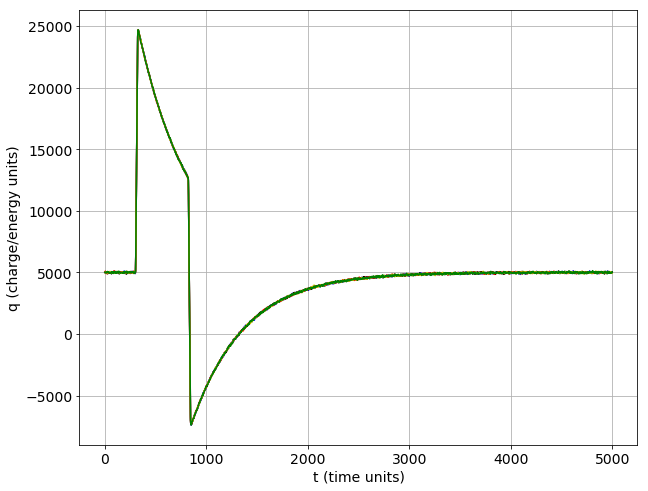

In [63]:
plot_waveforms(pmts_fee)

#### all the waveforms start now in the same t0

In [64]:
pmts_blr = deconv_pmts(pmts_fee, coef)

Time spent in deconv_pmts: 0.0001990795135498047 s


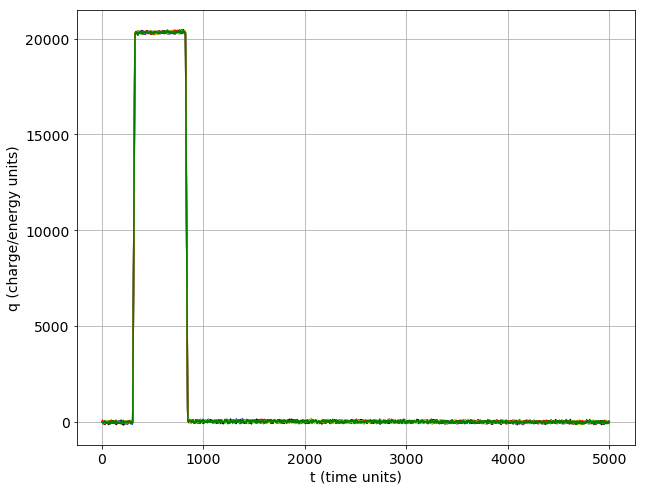

In [65]:
plot_waveforms(pmts_blr)

In [66]:
adc_to_pes = np.ones(nsensors) * 100

In [67]:
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(pmts_blr, adc_to_pes, n_MAU = 100, thr_MAU = 3)

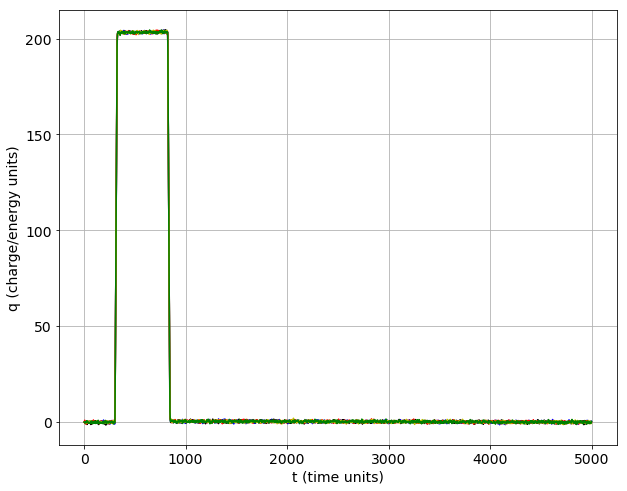

In [68]:
plot_waveforms(ccwfs)

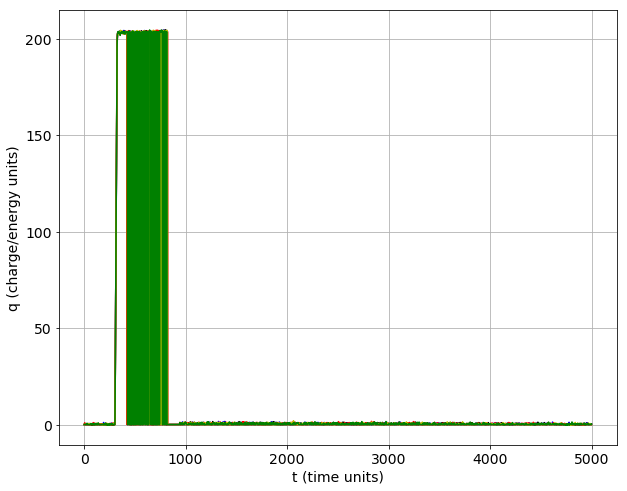

In [69]:
plot_waveforms(ccwfs_mau)

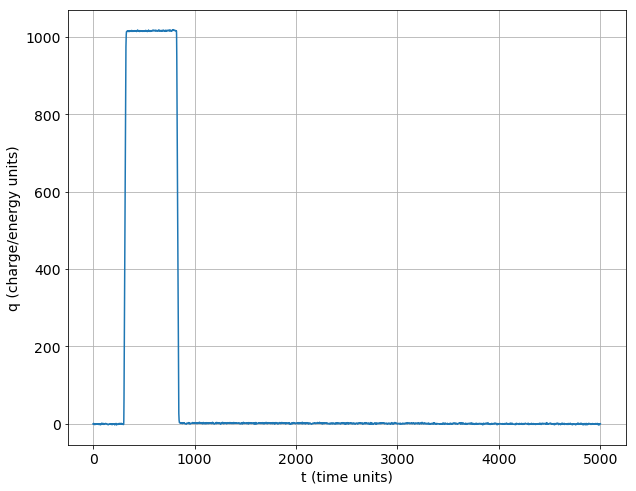

In [70]:
plot_wfm(cwf_sum)

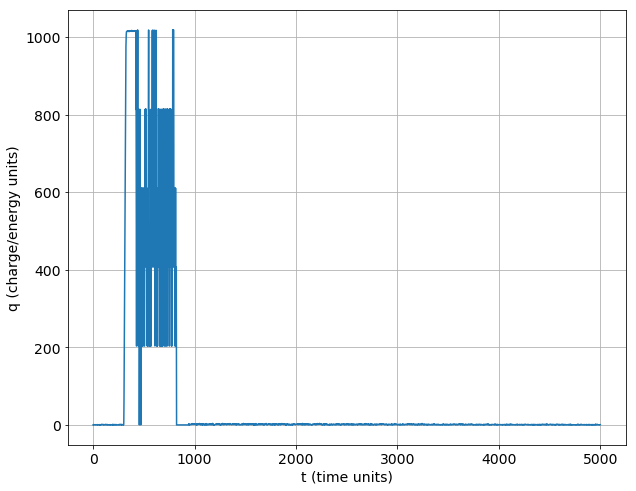

In [71]:
plot_wfm(cwf_sum_mau)

In [72]:
np.sum(cwf_sum[500:1100])

340708.77684741624

In [73]:
np.sum(ccwfs[0][500:1100]) * nsensors

340712.70936469047

In [74]:
list(map(np.sum, [c[500:1100] for c in ccwfs]))

[68142.541872938091,
 68159.456855707118,
 68141.229988135165,
 68141.333283531843,
 68124.214847103984]

In [75]:
cf.relative_difference(np.sum(cwf_sum[500:1100]), reduce(add, list(map(np.sum, [c[500:1100] for c in ccwfs]))))

1.708428572109701e-16

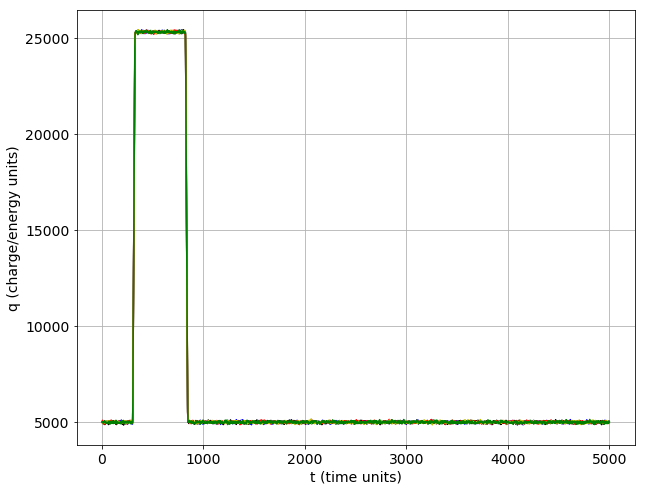

In [76]:
plot_waveforms(sipms_wfm)

### Calibrate SiPMs

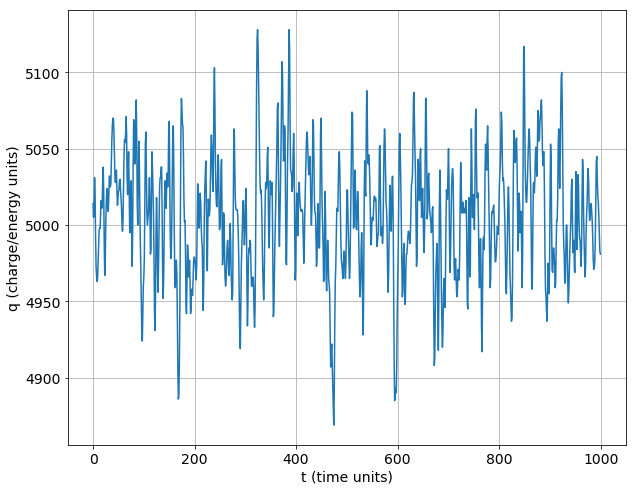

In [77]:
plot_wfm(sipms_wfm[0][1000:2000])

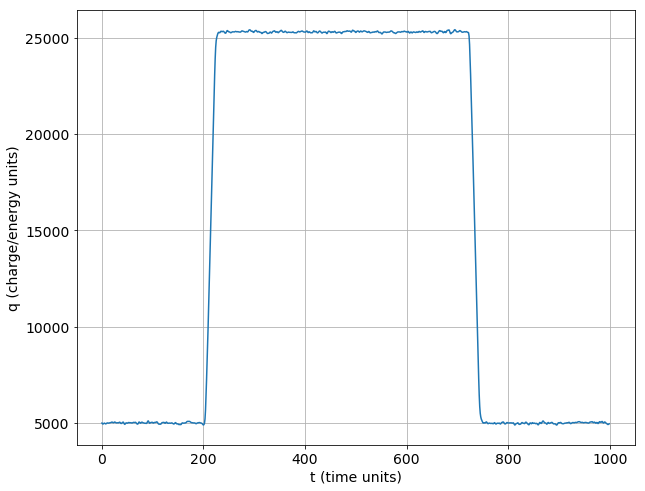

In [78]:
plot_wfm(sipms_wfm[0][100:1100])

In [79]:
cwfs = csf.calibrate_sipms(sipms_wfm, adc_to_pes, thr=10, bls_mode=csf.BlsMode.amode)

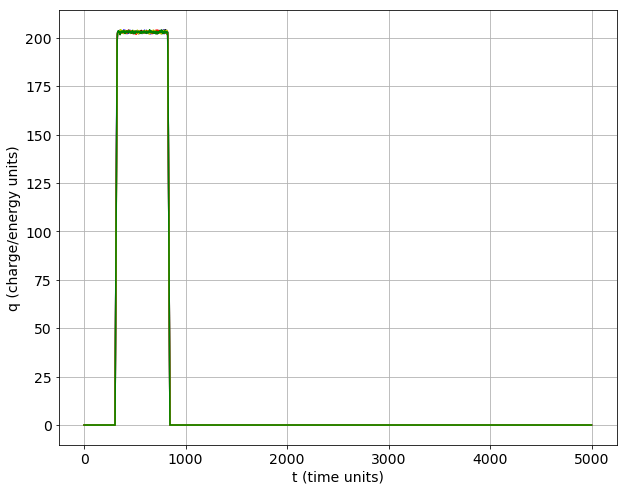

In [80]:
plot_waveforms(cwfs)

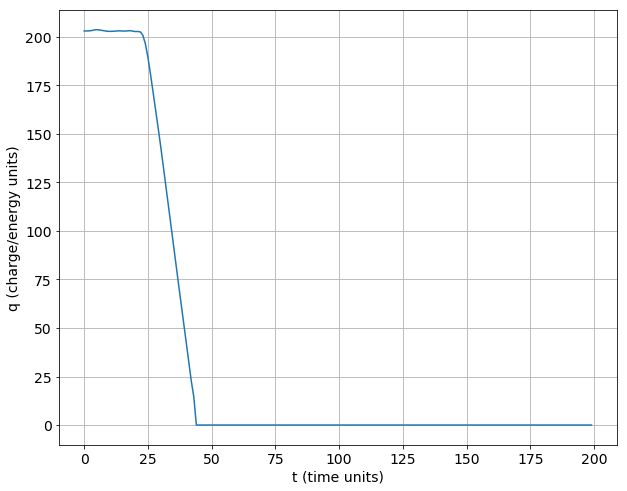

In [81]:
plot_wfm(cwfs[0][800:1000])

In [82]:
np.sum(cwfs[0][0:850])

105536.0

In [83]:
rsum = np.sum(cwfs[0]) * nsensors

In [84]:
sums = list(map(np.sum, [c for c in cwfs]))

In [85]:
rsum2 = reduce(add, sums)

In [86]:
cf.relative_difference(rsum, rsum2)

0.00016261749545167425

## Tests

In [162]:
def square_pmt_and_sipm_waveforms():
    pedestal = 5000
    nsensors =    5
    fee = FE.FEE(noise_FEEPMB_rms=1*FE.NOISE_I,noise_DAQ_rms=1*FE.NOISE_DAQ)
    coef = fee.freq_LHPFd*np.pi
    wfp = wfg.WfmPar(w_type='square', t_tot=5000*25,t_pre=600*25,
                     t_rise_s2=20*25,t_flat_s2=500*25,noise=1,q_s2=50)

    wfms = wfg.waveform_generator(fee, wfp, nsensors=nsensors, pedestal=pedestal, random_t0=False)
    pmts_fee  = wfms.fee
    pmts_blr  = wfms.blr
    pmts_BLR = wfg.deconv_pmts(pmts_fee, coef)
    sipms_wfm = wfms.blr
    sipms_noped = np.array( [wfm - np.ones(len(wfm)) * pedestal for wfm in sipms_wfm]).astype(int)
    
    return pedestal, nsensors, pmts_fee, pmts_blr, pmts_BLR, sipms_wfm, sipms_noped
    

In [163]:
def test_mean_for_pmts_fee_is_unbiased():
    _, _, pmts_fee, _, _, _, _ = square_pmt_and_sipm_waveforms() 
    pmts_bls = csf.subtract_mean(pmts_fee)  # ped subtracted near zero
    sums  = list(map(np.sum, [c for c in pmts_bls])) #cancel fluctuations very close to zeo
    assert np.allclose(sums, np.zeros(len(sums)))   

In [164]:
def test_areas_pmts_are_close():
    _, nsensors, _, _, pmts_BLR, _, _ = square_pmt_and_sipm_waveforms()
    adc_to_pes = np.full(nsensors, 100, dtype=np.float)
    ccwfs, _, cwf_sum, _ = csf.calibrate_pmts(pmts_BLR, adc_to_pes)
    sums  = list(map(np.sum, [c for c in ccwfs]))
    assert all_elements_close(sums, t_rel=1e-2)

In [165]:
def test_area_of_sum_equals_sum_of_areas_pmts():
    _, nsensors, _, _, pmts_BLR, _, _ = square_pmt_and_sipm_waveforms()
    adc_to_pes = np.full(nsensors, 100, dtype=np.float)
    ccwfs, _, cwf_sum, _ = csf.calibrate_pmts(pmts_BLR, adc_to_pes)
    stot  = np.sum(cwf_sum)
    sums  = list(map(np.sum, [c for c in ccwfs]))
    stot2 = reduce(add, sums) 
    assert stot ==approx(stot2)

In [166]:
def test_area_of_sum_equals_sum_of_areas_sipms():
    _, nsensors, _, _, _, sipms_wfm, _ = square_pmt_and_sipm_waveforms()
    adc_to_pes = np.full(nsensors, 100, dtype=np.float)
    cwfs = csf.calibrate_sipms(sipms_wfm, adc_to_pes, thr=10, bls_mode=csf.BlsMode.amode)
    stot = np.sum(cwfs[0]) * nsensors
    sums  = list(map(np.sum, [c for c in cwfs]))
    stot2 = reduce(add, sums) 
    assert stot ==approx(stot2, rel=1e-3)

In [167]:
def test_mean_for_square_waveform_is_biased():
    _, _, _, _, _, sipms_wfm, sipms_noped = square_pmt_and_sipm_waveforms()
    sipms_mean = csf.subtract_baseline(sipms_wfm, bls_mode=csf.BlsMode.mean)
    diffs =np.array([x - y for x, y in zip(sipms_noped, sipms_mean)])
    assert np.mean(diffs[0]) > 2000

In [168]:
def test_median_for_square_waveform_has_small_bias():
    _, _, _, _, _, sipms_wfm, sipms_noped = square_pmt_and_sipm_waveforms()
    sipms_median = csf.subtract_baseline(sipms_wfm, bls_mode=csf.BlsMode.median)
    diffs =np.array([x - y for x, y in zip(sipms_noped, sipms_median)])
    assert np.mean(diffs[0]) < 10

In [169]:
def test_mode_for_square_waveform_has_no_bias():
    _, _, _, _, _, sipms_wfm, sipms_noped = square_pmt_and_sipm_waveforms()
    sipms_mode = csf.subtract_baseline(sipms_wfm, bls_mode=csf.BlsMode.amode)
    diffs =np.array([x - y for x, y in zip(sipms_noped, sipms_mode)])
    assert np.mean(diffs[0]) ==approx(0) 

In [170]:
test_mean_for_pmts_fee_is_unbiased()

In [171]:
test_area_of_sum_equals_sum_of_areas_pmts()

In [172]:
test_area_of_sum_equals_sum_of_areas_sipms()

In [173]:
test_mean_for_square_waveform_is_biased()

In [174]:
test_median_for_square_waveform_has_small_bias()

In [175]:
test_mode_for_square_waveform_has_no_bias()

In [176]:
test_areas_pmts_are_close()